In [58]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import random
from jax import jit
from functools import partial
import time

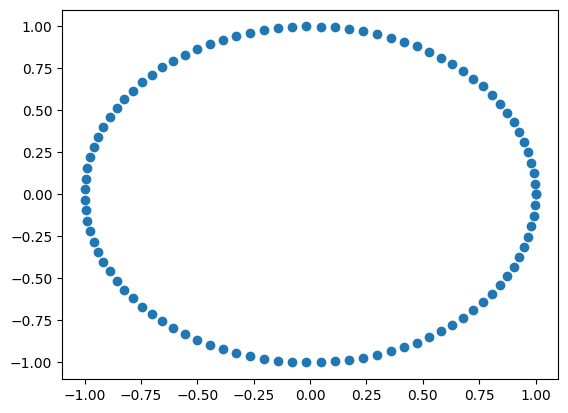

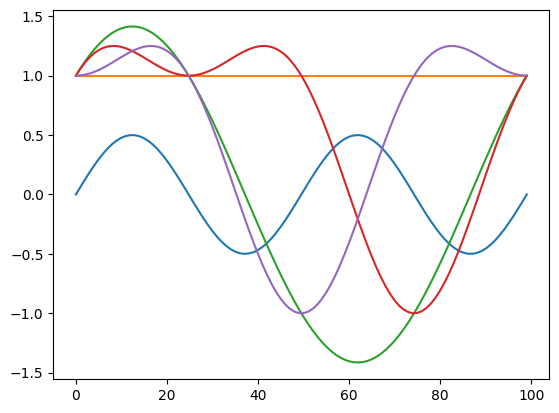

In [59]:
N = 100
D = 5

# 真の潜在変数を生成
t = np.linspace( 0, 2*np.pi, N )
z_true = np.zeros( (N, 2)  )

z_true[:,0] = np.cos(t)
z_true[:,1] = np.sin(t)

plt.plot( z_true[:,0], z_true[:,1], "o" )

# 潜在変数を適当に高次限化
x = np.zeros( (N, D) )
x[:,0] = [ z1*z2 for (z1,z2) in z_true ]
x[:,1] = [ z1*z1+z2*z2 for (z1,z2) in z_true ]
x[:,2] = [ z1 + z2 for (z1,z2) in z_true ]
x[:,3] = [ z1*z1+z2 for (z1,z2) in z_true ]
x[:,4] = [ z2*z2+z1 for (z1,z2) in z_true ]

plt.figure()
for i in range(D):
  plt.plot( range(N), x[:,i])

In [60]:
class GPLVM:
  def __init__(self, latend_dim ):
    self.latent_dim = latend_dim
    self.alpha = 1.0
    self.beta = 10.0

  @partial(jit, static_argnums=(0,))
  def k(self, xi, xj):
    return 1.0 * jnp.exp(-0.5 * 1.0 * jnp.sum((xi - xj) * (xi - xj), 2))

  @partial(jit, static_argnums=(0,3))
  def cov(self, xi, xj, dim ):
    a = jnp.tile( xi.reshape(-1,1,dim), (1, len(xj), 1) )
    b = jnp.tile( xj.reshape(1,-1,dim), (len(xi), 1, 1) )
    return self.k(a,b)

  # 位置エネルギー
  @partial(jit, static_argnums=(0,))
  def calc_h(self, Z):
    return -self.calc_loglik(Z)

  # ハミルトニアン（位置エネルギー＋運動エネルギー）
  @partial(jit, static_argnums=(0,))
  def calc_hamiltonian(self, p, Z):
      return  self.calc_h(Z) + 0.5*jnp.sum(p**2)

  def learn(self, X, num_itr, step=0.1, p_scale=1.0, Z=None):
    self.N = len(X)
    self.D = len(X[0])
    self.X = jnp.asarray(X)
    liks = []

    # 初期化
    if Z is None:
      Z = jnp.zeros( (N, self.latent_dim), dtype=float )
      #Z = jnp.asarray( np.random.randn( N, self.latent_dim ) )

    plt.plot( Z[:,0], Z[:,1], "o" )
    plt.show()

    # 位置エネルギーの導関数
    cakc_diff_h =  jax.grad( self.calc_h )

    # 速度
    p = np.random.normal(size=(N, self.latent_dim), loc=0,scale=p_scale)
    p = jnp.asarray(p)


    for itr in range(num_itr):
      prev_Z = Z.copy()
      prev_p = p.copy()
      prev_hamiltonian = self.calc_hamiltonian(p,Z)

      # ハミルトニアン（位置エネルギー＋運動エネルギ）が一定という条件で新たな位置Zと速度pを求める
      for i in range(5):
        # leap frog法：計算制度をあ高めるために0.5stepずつ計算
        p = p - 0.5 * step* cakc_diff_h(Z)
        Z = Z + step*p
        p = p - 0.5 * step* cakc_diff_h(Z)

      new_hamiltonian = self.calc_hamiltonian(p,Z)

      r = np.exp(prev_hamiltonian-new_hamiltonian)
      if  r >  np.random.uniform():
        pass
      else:
        print("reject")
        Z = prev_Z
        p = prev_p

      # 新たにガウス分布に従い速度を与える
      p = np.random.normal(size=(N,self.latent_dim),loc=0,scale=p_scale)
      p = jnp.asarray(p)

      if itr%10==0:
        s = time.time()

        lik = self.calc_loglik( Z )
        print(lik)
        plt.plot( Z[:,0], Z[:,1], "o" )
        plt.show()
        print( "lik:", time.time()-s )

    return Z

  @partial(jit, static_argnums=(0,))
  def calc_loglik(self, Z ):
    K = self.alpha * self.cov(Z, Z, self.latent_dim) + 1/self.beta * jnp.eye(self.N, self.N)
    K_inv = jnp.linalg.inv( K )

    return -self.D/2*jnp.log( jnp.linalg.det(K)+0.000000000000000001 ) -1/2 * jnp.trace( K_inv@self.X@self.X.T )

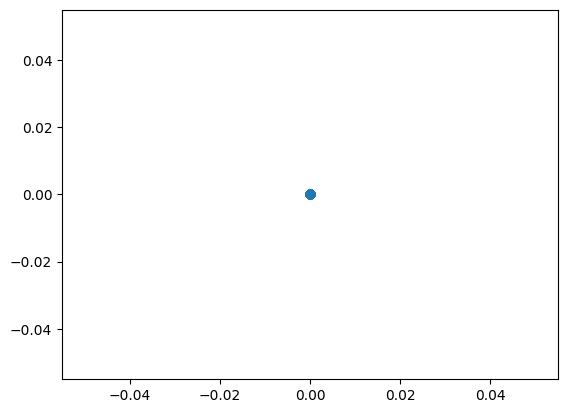

-790.44


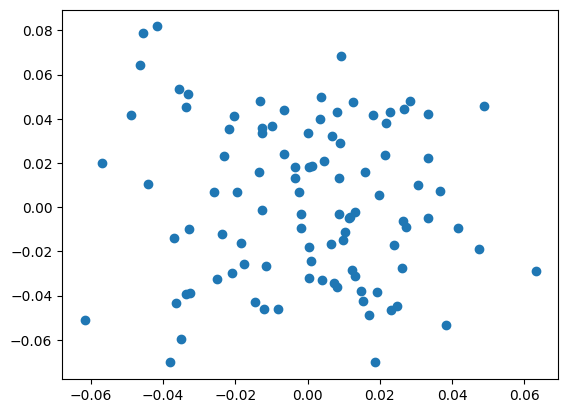

lik: 0.3868827819824219
-2.6472473


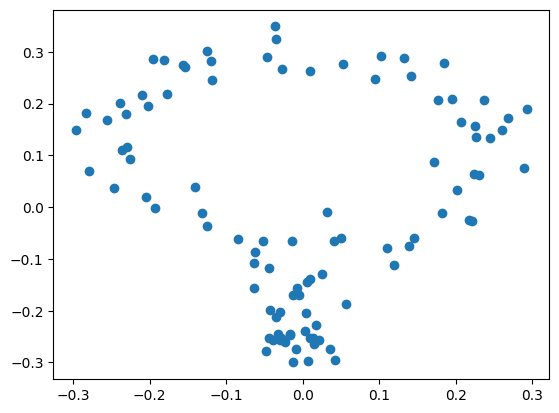

lik: 0.1618211269378662
reject
25.759018


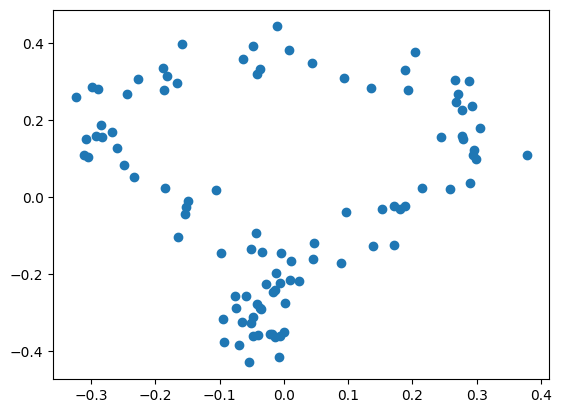

lik: 0.16395926475524902
38.77388


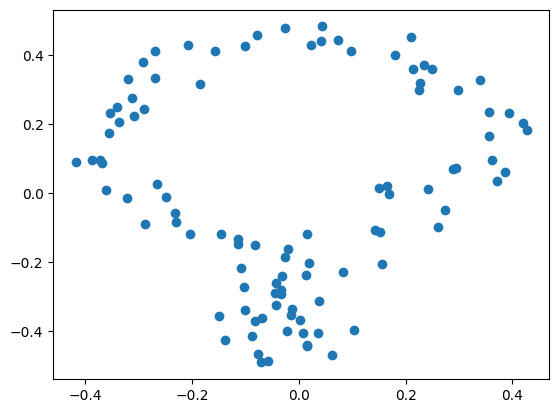

lik: 0.15458321571350098
42.383026


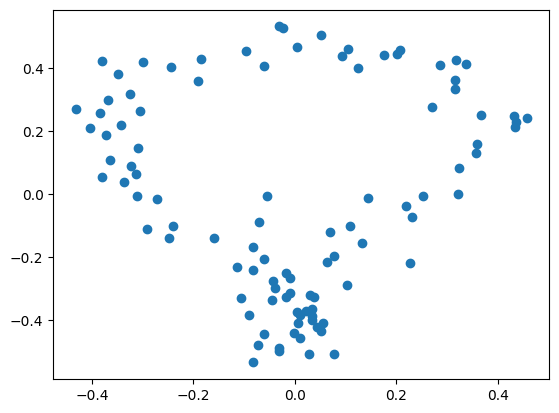

lik: 0.1546497344970703


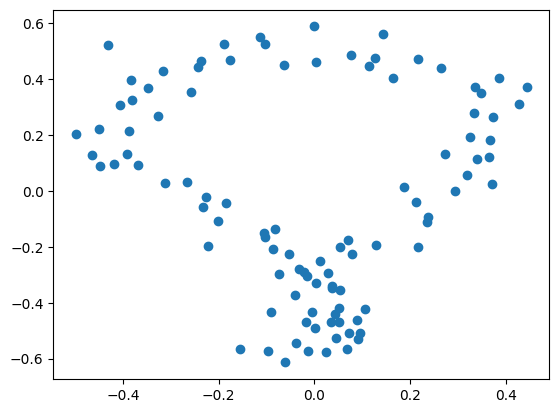

60.704792


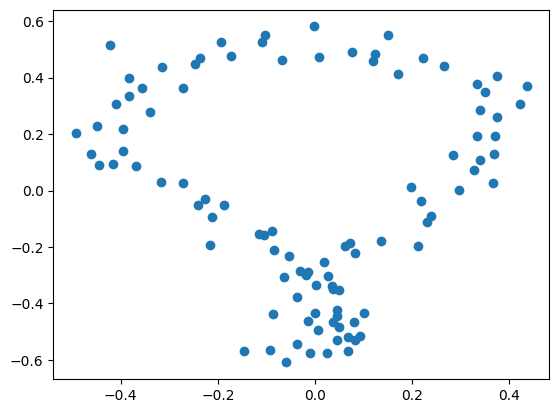

lik: 0.18802475929260254
77.03301


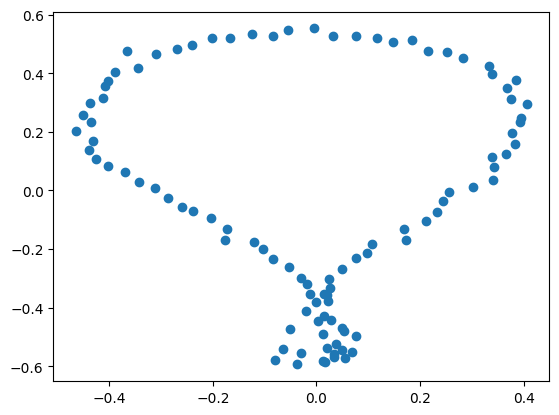

lik: 0.16280269622802734
79.79333


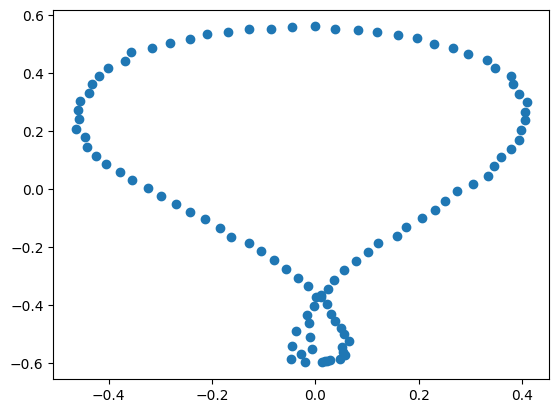

lik: 0.25441431999206543
81.192406


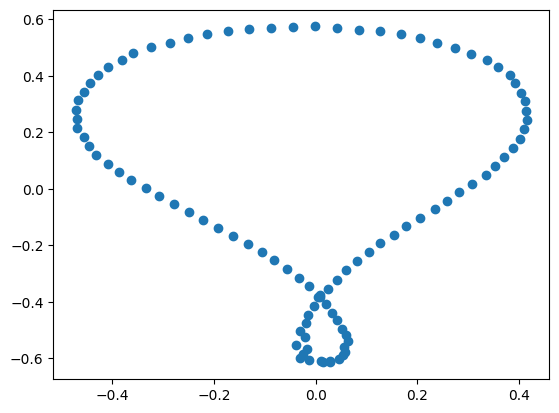

lik: 0.18103265762329102
82.25104


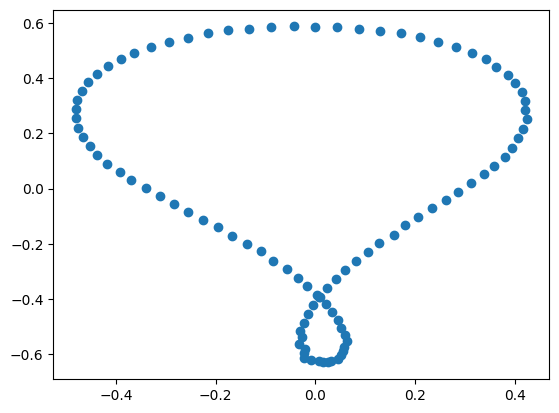

lik: 0.18125128746032715
8.396693229675293


In [62]:
gp = GPLVM(2)
s = time.time()
Z = gp.learn(x, 50, 0.01, p_scale=0.5)
Z = gp.learn(x, 50, 0.01, p_scale=0.01, Z=Z)
print( time.time()-s )